In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_curve, \
auc, precision_recall_curve, accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [2]:
def oneHotEncoded(data_frame, column_name_ls):
    df = data_frame.copy(deep=True)
    for col in column_name_ls:
        df[col] = pd.Categorical(df[col])
        df_dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, df_dummies], axis=1)
        df.drop([col], axis=1, inplace=True)
        
    return df

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

total_charges_filter = df['TotalCharges'] == ' '
df = df[~total_charges_filter]
# df.head() # ~(7032, 21)

In [4]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner',
 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
 'PaymentMethod'] # ~16
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target = 'Churn'

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a44ca60d0>,
      dtype=object)

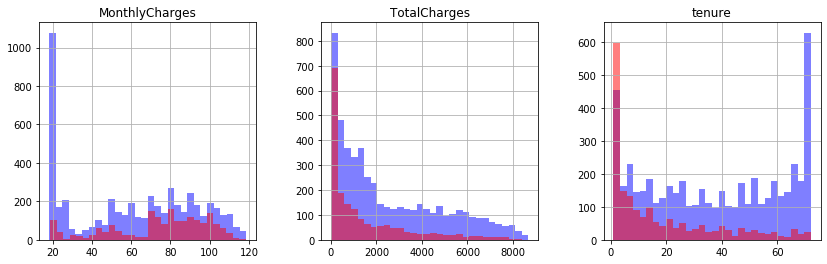

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

In [5]:
label = df['Churn'].map({'Yes': 1, 'No': 0})
# label.head()

In [6]:
data = oneHotEncoded(df.drop(['customerID','Churn'], axis=1), categorical_features)

In [7]:
data_numpy = data.to_numpy(copy=True)
label_numpy = label.to_numpy(copy=True)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data_numpy, label_numpy, test_size= 0.2)

### DNN train with 10 kfolds

In [17]:
def evaluate_dnn(x_train, x_test, y_train, y_test, i):
    EPOCHS = 200
    LR = 0.00
    
    dnn = keras.Sequential([
        keras.layers.Dense(46, activation='relu', input_shape=(46,)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
#         keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
#         keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    adam = keras.optimizers.Adam(learning_rate=LR)
    dnn.compile(optimizer=adam, loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="dnn_weight/iter_{}.hdf5".format(i), 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)
        
    history = dnn.fit(x_train, y_train, batch_size=64, validation_data=(x_test, y_test),
                    epochs=EPOCHS, callbacks=[checkpointer], verbose=False)
    
    acc = dnn.evaluate(x_test, y_test, verbose=False)[1]
    return history, acc

In [18]:
def dnn_kfold(X, Y, folds):    
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    model_result = []
    
    fig, axes = plt.subplots(nrows=folds, ncols=2, figsize=(20,40))
    axes = axes.flatten()
    
    for i, (train, test) in enumerate(kfold.split(X, Y)):
      # create model
        history, acc = evaluate_dnn(X[train], X[test], Y[train], Y[test], i)
    #   evaluate the model
        model_result.append(acc)
        
        axes[2*i].plot(history.history['accuracy'])
        axes[2*i].plot(history.history['val_accuracy'])
        axes[2*i].set_title('Iteration {}'.format(i))
        axes[2*i].set_ylabel('Accuracy')
        axes[2*i].set_xlabel('Epoch')
        axes[2*i].legend(['Train', 'Validation'], loc='center right')
        
        axes[(2*i) + 1].plot(history.history['loss'])
        axes[(2*i) + 1].plot(history.history['val_loss'])
        axes[(2*i) + 1].set_title('Model loss')
        axes[(2*i) + 1].set_ylabel('Loss')
        axes[(2*i) + 1].set_xlabel('Epoch')
        axes[(2*i) + 1].legend(['Train', 'Validation'], loc='center right')
        
    return model_result, fig

In [21]:
def evaluate_all_model(data, label, iteration):
    
    model_result = defaultdict(list)
    
    fig, axes = plt.subplots(nrows=iteration, ncols=2, figsize=(20,40))
    axes = axes.flatten()
    for i in range(iteration):
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size= 0.2)
        
        lr = LogisticRegression()
        svm = SVC(probability=True)
        rfc = RandomForestClassifier(n_estimators=100,
                                random_state= 1234)
    
        lr.fit(x_train, y_train)
        y_pred_lr = lr.predict(x_test)
        model_result['logistic_regression'].append(metrics.accuracy_score(y_test, y_pred_lr))
        
        svm.fit(x_train, y_train)
        y_pred_svm = svm.predict(x_test)
        model_result['svm'].append(metrics.accuracy_score(y_test, y_pred_svm))
        
        rfc.fit(x_train,y_train)
        y_pred_rfc = rfc.predict(x_test)
        model_result['random_forest'].append(metrics.accuracy_score(y_test, y_pred_rfc))
        
        history, acc = evaluate_dnn(x_train, x_test, y_train, y_test, i)
        model_result['dnn'].append(acc)
        #plot graph and save as a image
        
        axes[2*i].plot(history.history['accuracy'])
        axes[2*i].plot(history.history['val_accuracy'])
        axes[2*i].set_title('Iteration {}'.format(i))
        axes[2*i].set_ylabel('Accuracy')
        axes[2*i].set_xlabel('Epoch')
        axes[2*i].legend(['Train', 'Validation'], loc='center right')
        
        axes[(2*i) + 1].plot(history.history['loss'])
        axes[(2*i) + 1].plot(history.history['val_loss'])
        axes[(2*i) + 1].set_title('Model loss')
        axes[(2*i) + 1].set_ylabel('Loss')
        axes[(2*i) + 1].set_xlabel('Epoch')
        axes[(2*i) + 1].legend(['Train', 'Validation'], loc='center right')
        
    return model_result, fig
        


Epoch 00001: val_accuracy improved from -inf to 0.76909, saving model to dnn_weight/iter_0.hdf5

Epoch 00002: val_accuracy improved from 0.76909 to 0.79218, saving model to dnn_weight/iter_0.hdf5

Epoch 00003: val_accuracy improved from 0.79218 to 0.79396, saving model to dnn_weight/iter_0.hdf5

Epoch 00004: val_accuracy improved from 0.79396 to 0.80284, saving model to dnn_weight/iter_0.hdf5

Epoch 00005: val_accuracy did not improve from 0.80284

Epoch 00006: val_accuracy did not improve from 0.80284

Epoch 00007: val_accuracy did not improve from 0.80284

Epoch 00008: val_accuracy did not improve from 0.80284

Epoch 00009: val_accuracy did not improve from 0.80284

Epoch 00010: val_accuracy did not improve from 0.80284

Epoch 00011: val_accuracy improved from 0.80284 to 0.80639, saving model to dnn_weight/iter_0.hdf5

Epoch 00012: val_accuracy did not improve from 0.80639

Epoch 00013: val_accuracy did not improve from 0.80639

Epoch 00014: val_accuracy did not improve from 0.80639

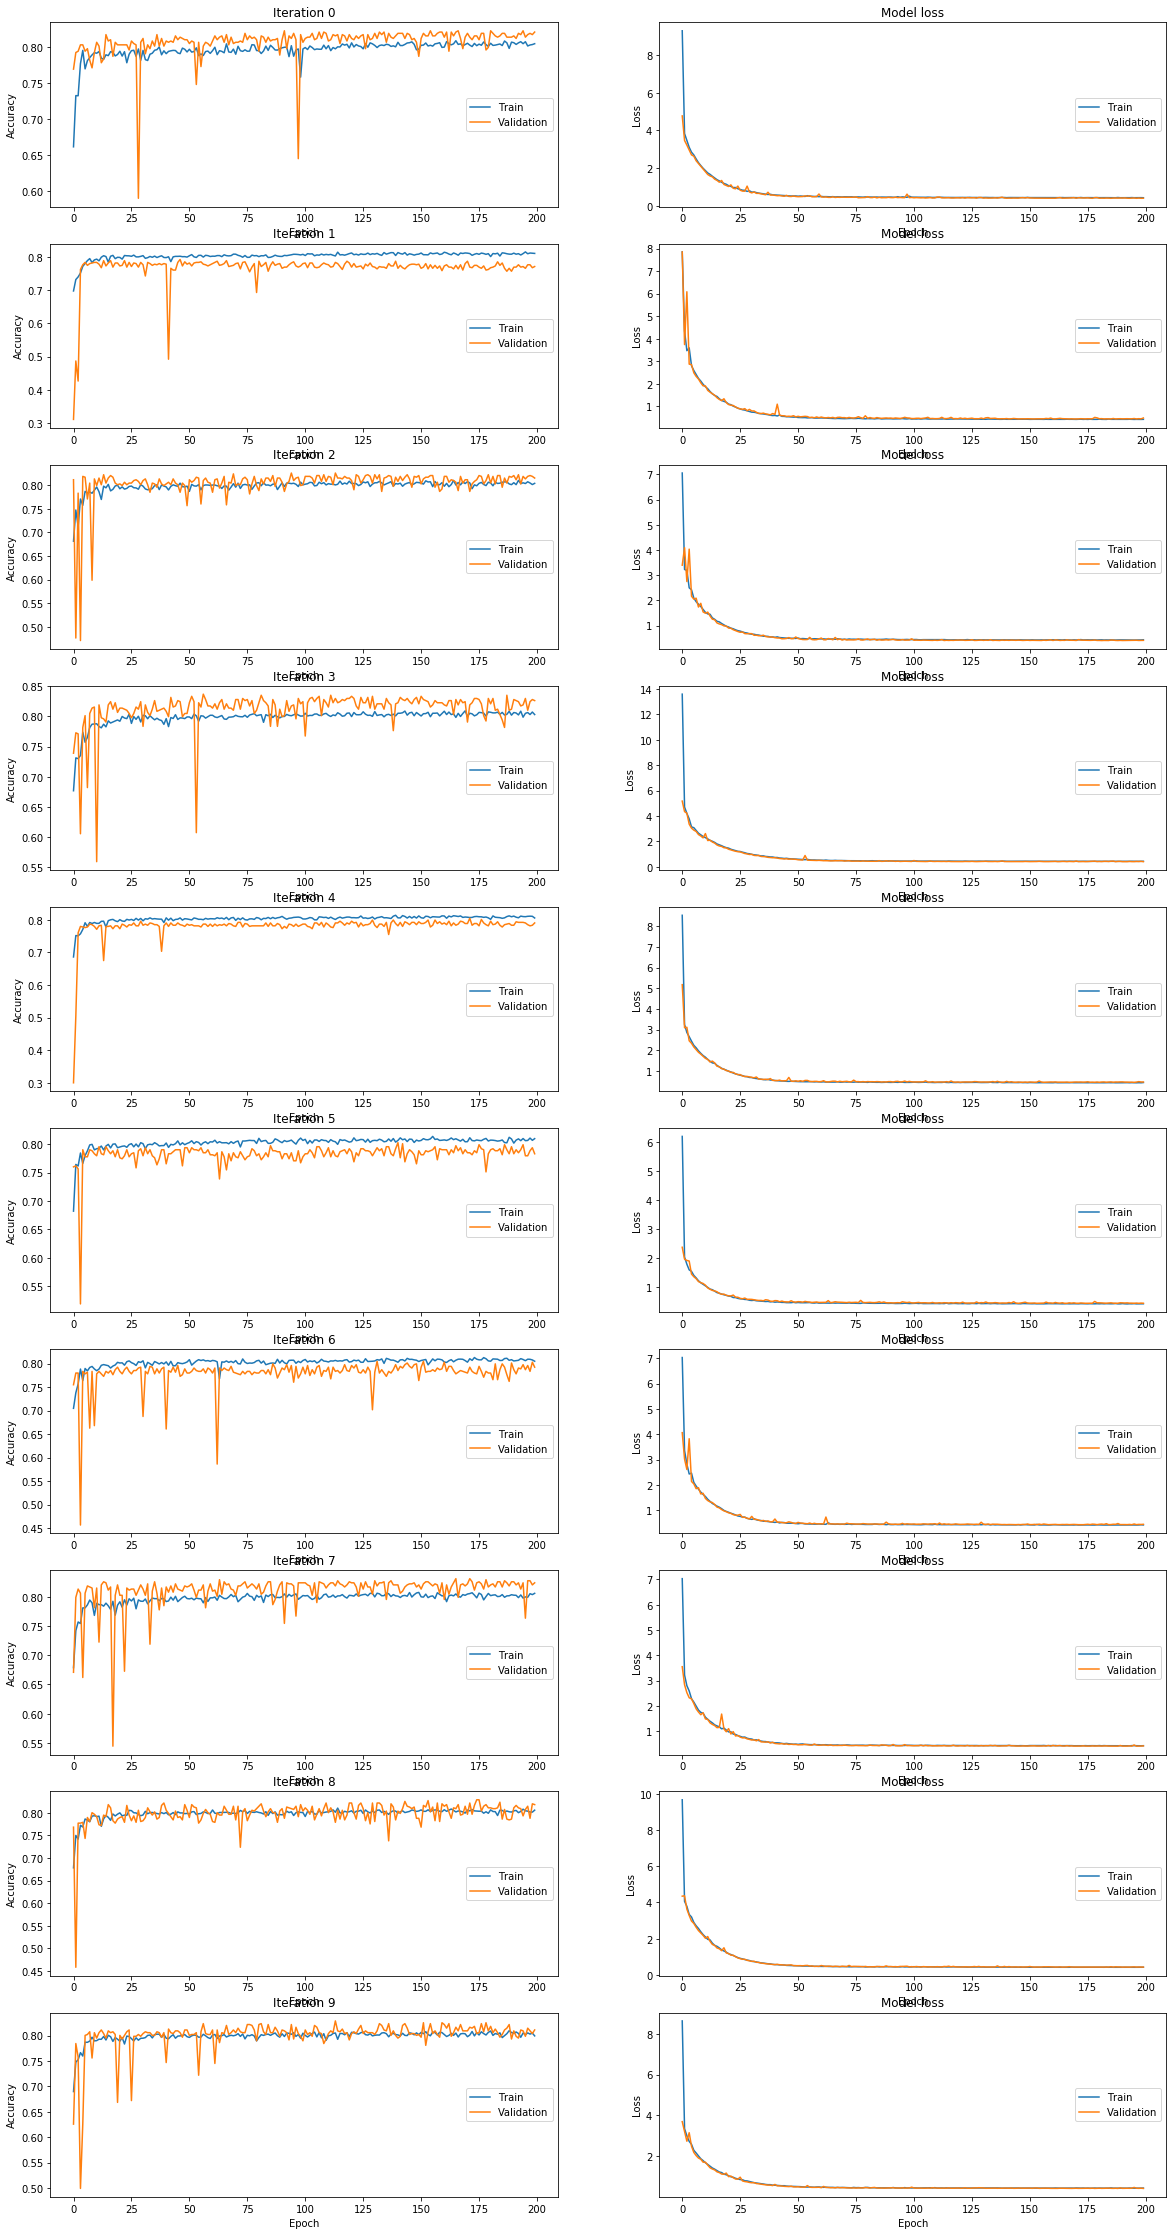

In [19]:
result, figure = dnn_kfold(x_train, y_train, 10)

In [29]:
print('Mean: {}, All:{}'.format(np.mean(result), result))

Mean: 0.8051655888557434, All:[0.8206039, 0.7708703, 0.8152753, 0.8259325, 0.79040855, 0.78330374, 0.7921847, 0.8238434, 0.8181818, 0.81105167]


In [21]:
figure.tight_layout()

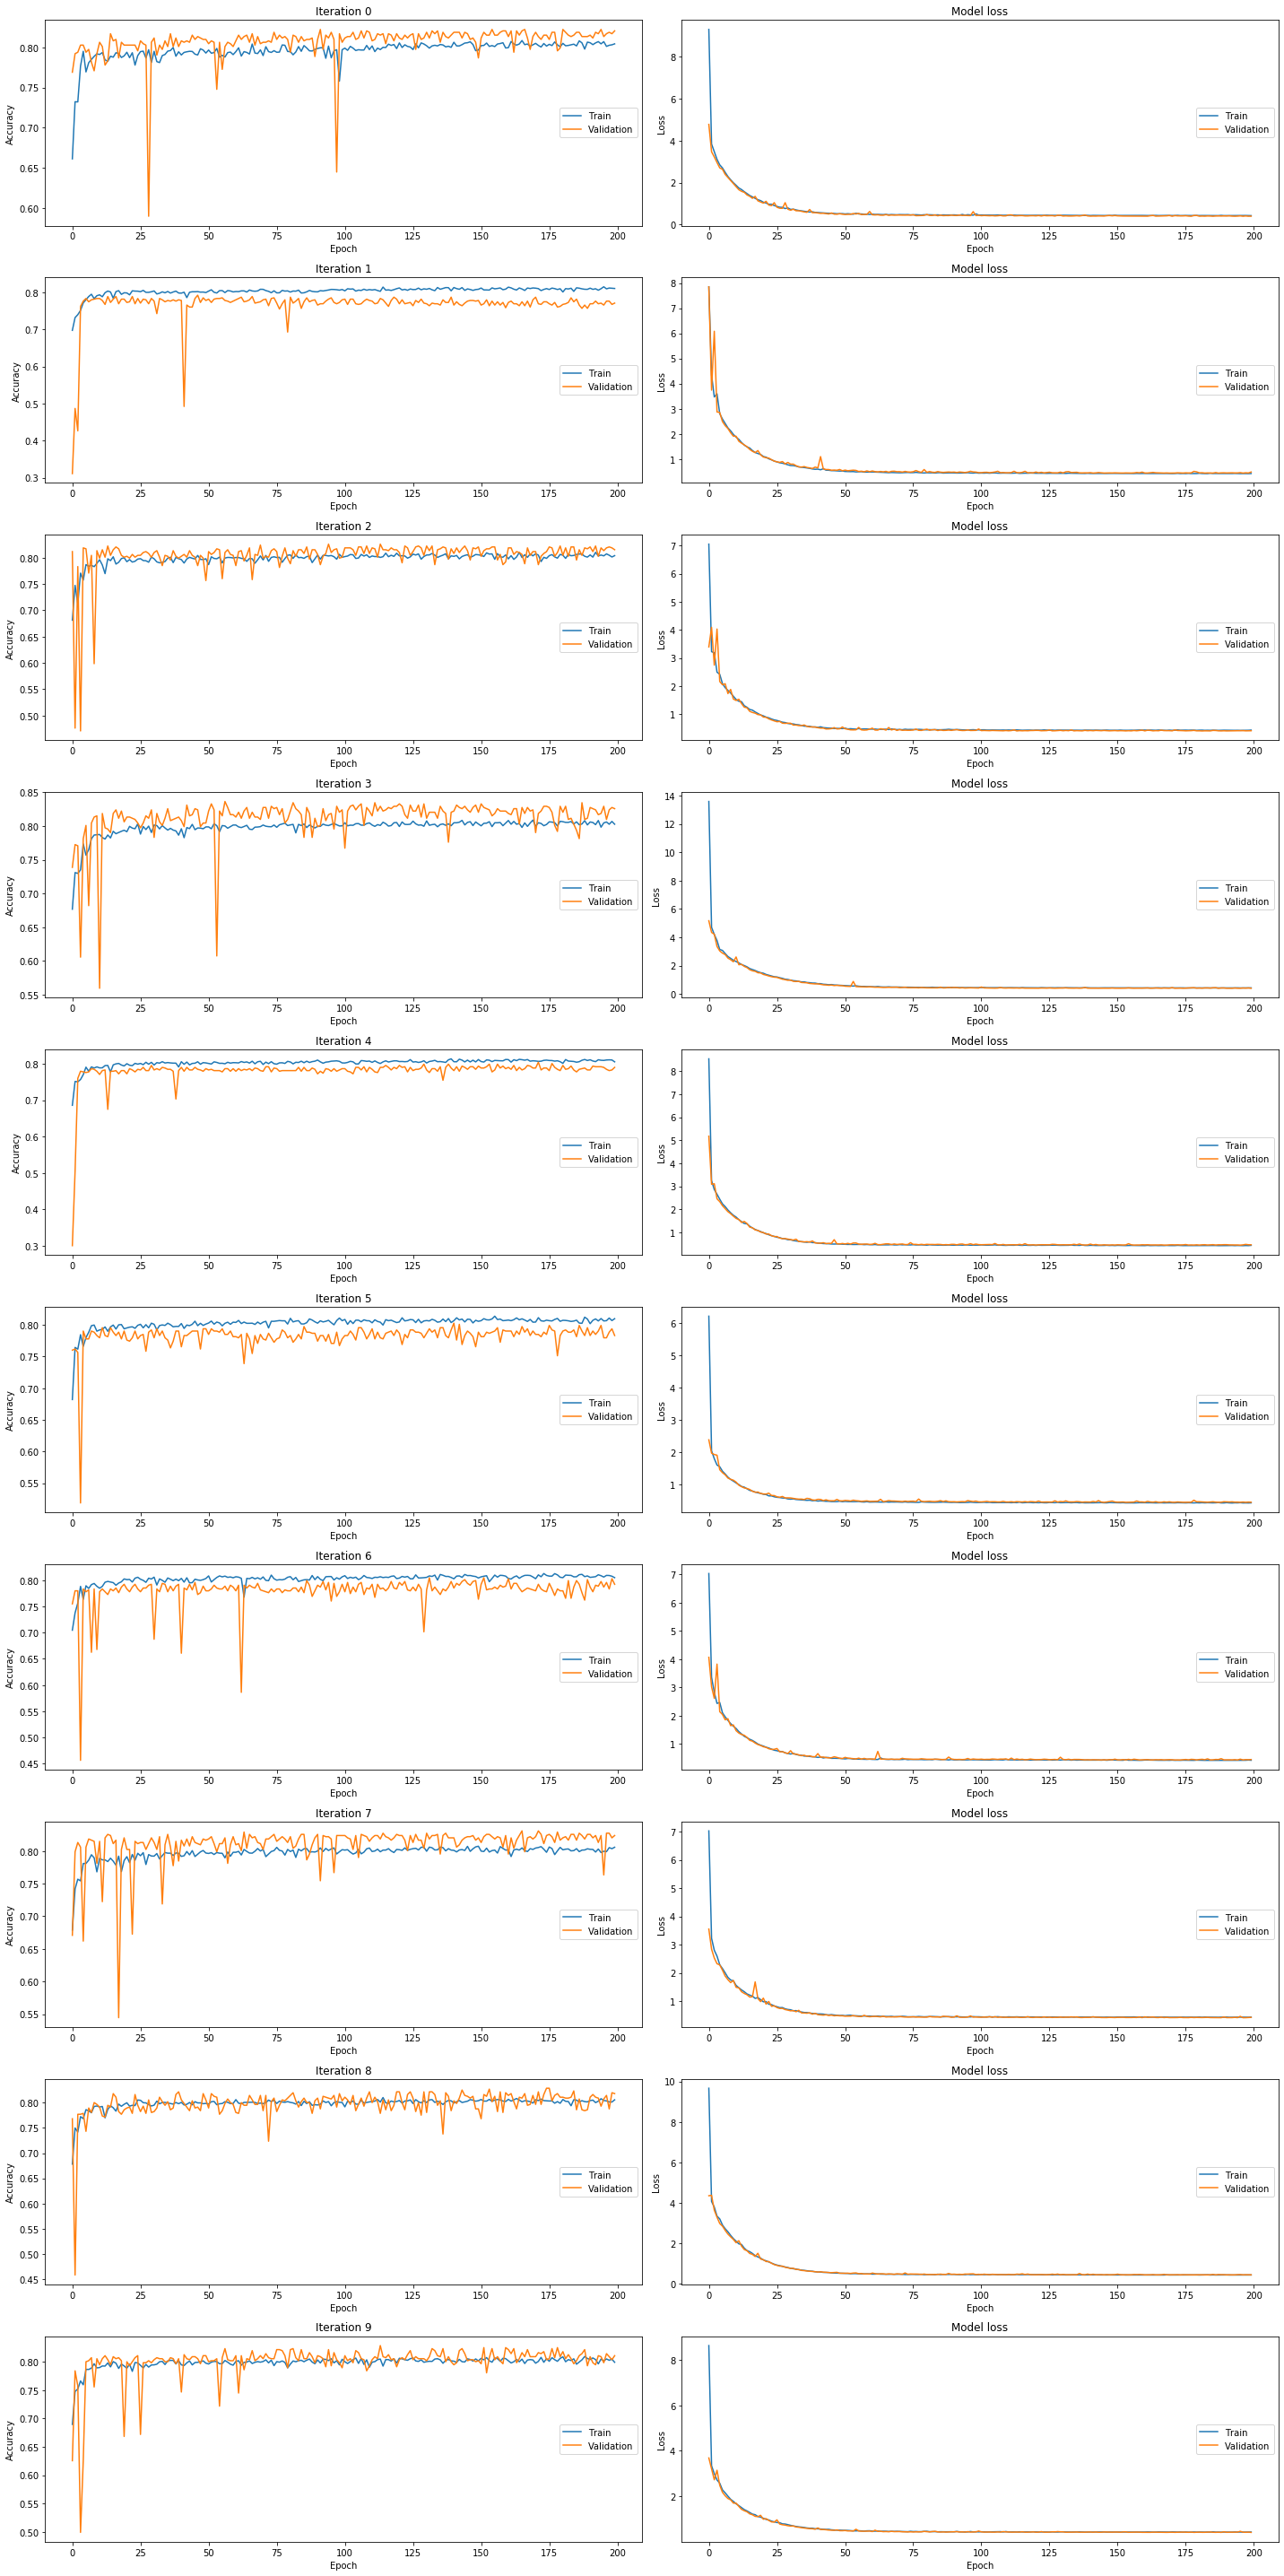

In [24]:
figure

## Logistic regression gridsearch

In [220]:
logistic = LogisticRegression()

penalty = ['l1', 'l2']

C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

lr_grid = GridSearchCV(logistic, hyperparameters, cv=10, verbose=0)
lr_grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

In [221]:
lr_pred = lr_grid.predict(x_test) 
  
print(classification_report(y_test, lr_pred))
print("Accuracy:",metrics.accuracy_score(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1029
           1       0.63      0.59      0.61       378

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.74      1407
weighted avg       0.79      0.80      0.79      1407

Accuracy: 0.7960199004975125


## SVM gridsearch

In [222]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
svc_grid = GridSearchCV(SVC(), param_grid, refit = True, cv=10) 
  
# fitting the model for grid search 
svc_grid.fit(x_train, y_train) 

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [223]:
# print best parameter after tuning 
# print(grid_svc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
# print(grid_svc.best_estimator_) 

svc_pred = svc_grid.predict(x_test) 
  
# print classification report 
print(classification_report(y_test, svc_pred))
print("Accuracy:",metrics.accuracy_score(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1029
           1       0.65      0.51      0.57       378

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407

Accuracy: 0.7931769722814499


## Random Forest gridsearch

In [224]:
rf_param = {
    'max_depth': [6,7,8,10],
    'n_estimators': [100, 300, 500],
    'criterion' :['gini', 'entropy']
}
rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param, cv= 10)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [225]:
rf_pred = rf_grid.predict(x_test) 
  
print(classification_report(y_test, rf_pred))
print("Accuracy:",metrics.accuracy_score(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1029
           1       0.67      0.54      0.60       378

    accuracy                           0.80      1407
   macro avg       0.76      0.72      0.73      1407
weighted avg       0.80      0.80      0.80      1407

Accuracy: 0.8045486851457001


In [74]:
rfc = RandomForestClassifier(n_estimators=300,
                                 random_state=1234,
                                 max_depth=8, criterion='gini')
rfc.fit(x_train, y_train)
rf_pred = rfc.predict(x_test) 
  
print(classification_report(y_test, rf_pred))
print("Accuracy:",metrics.accuracy_score(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1020
           1       0.64      0.46      0.53       387

    accuracy                           0.78      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

Accuracy: 0.7810945273631841


No handles with labels found to put in legend.


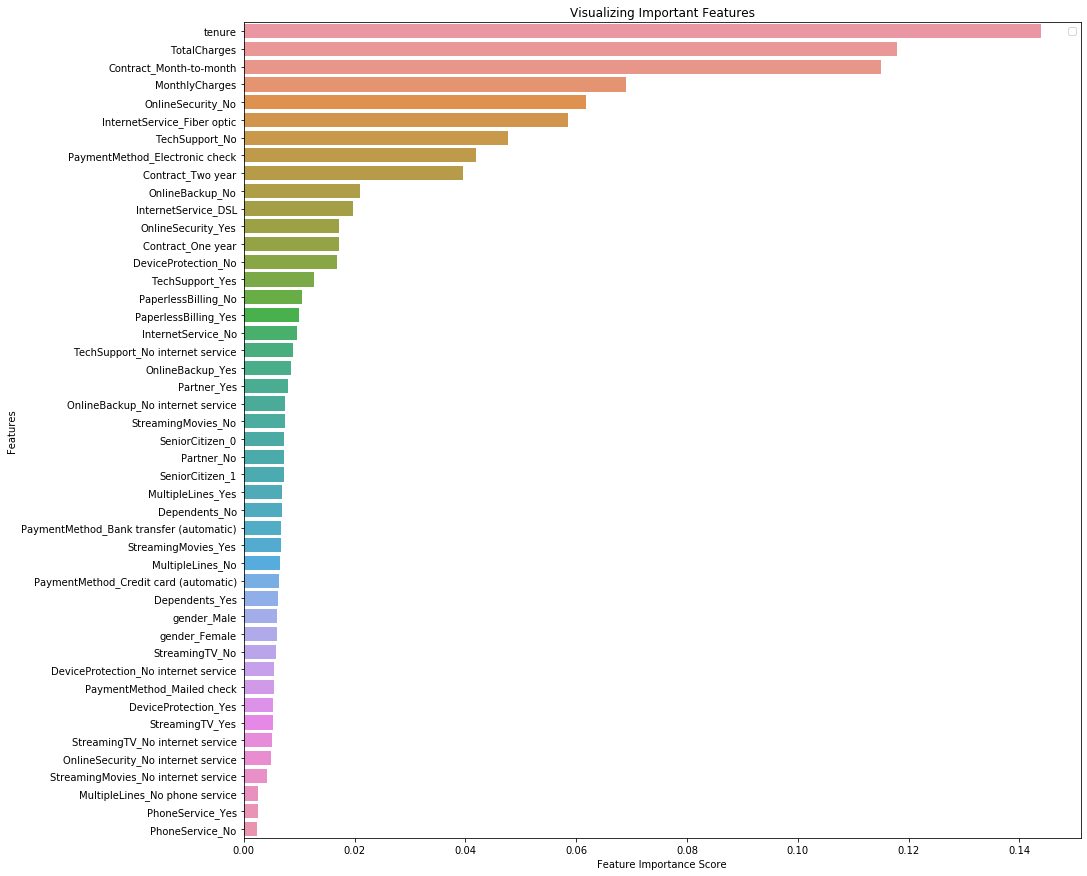

In [75]:
feature_imp = pd.Series(rfc.feature_importances_,index=list(data.columns.values)).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(15,15))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


## DNN evaluate with test set

In [9]:
EPOCHS = 200
LR = 0.003
model = keras.Sequential([
    keras.layers.Dense(46, activation='relu', input_shape=(46,)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
#     keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
#     keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
    keras.layers.Dense(1, activation='sigmoid')
])
adam = keras.optimizers.Adam(learning_rate= LR)
model.compile(optimizer=adam, loss='binary_crossentropy',
             metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 46)                2162      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1504      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,811
Trainable params: 5,811
Non-trainable params: 0
_________________________________________________________________


In [209]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="dnn_weight/best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [210]:
history = model.fit(x_train, y_train, batch_size=64, 
                    epochs=EPOCHS, callbacks=[checkpointer], validation_split=0.2,verbose=False)


Epoch 00001: val_accuracy improved from -inf to 0.76711, saving model to dnn_weight/best_weights.hdf5

Epoch 00002: val_accuracy did not improve from 0.76711

Epoch 00003: val_accuracy improved from 0.76711 to 0.78489, saving model to dnn_weight/best_weights.hdf5

Epoch 00004: val_accuracy improved from 0.78489 to 0.79378, saving model to dnn_weight/best_weights.hdf5

Epoch 00005: val_accuracy did not improve from 0.79378

Epoch 00006: val_accuracy did not improve from 0.79378

Epoch 00007: val_accuracy did not improve from 0.79378

Epoch 00008: val_accuracy improved from 0.79378 to 0.79911, saving model to dnn_weight/best_weights.hdf5

Epoch 00009: val_accuracy did not improve from 0.79911

Epoch 00010: val_accuracy did not improve from 0.79911

Epoch 00011: val_accuracy did not improve from 0.79911

Epoch 00012: val_accuracy did not improve from 0.79911

Epoch 00013: val_accuracy improved from 0.79911 to 0.80444, saving model to dnn_weight/best_weights.hdf5

Epoch 00014: val_accurac

In [60]:
model.load_weights('dnn_weight/iter_3.hdf5')
# model.load_weights('best_no_regularizer.hdf5')
# model.save('best_model.h5')

In [61]:
train_loss, train_acc  = model.evaluate(x_train, y_train, verbose=False)
print('Trained Acc: ', train_acc)
print('Trained Loss: ', train_loss)

test_loss, test_acc  = model.evaluate(x_test, y_test, verbose=False)
print('Tested Acc: ', test_acc)
print('Tested Loss: ', test_loss)

Trained Acc:  0.81155556
Trained Loss:  0.522332730823093
Tested Acc:  0.79957354
Tested Loss:  0.530045645492841


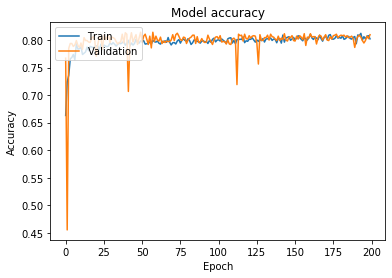

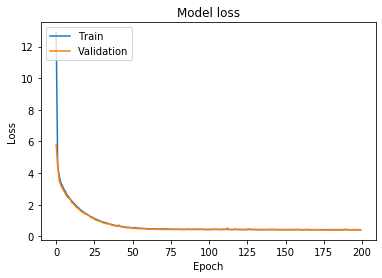

In [212]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [144]:
# {'batch_size': 64, 'epochs': 200, 'hidden_layers': 3, 'regularizers': 0.1, 'units': 32}

## Confusion Matrix

In [80]:
def confusion_matrix_plot(model, data, label):
    # train confusion matrix
    train_pred = np.round(model.predict(data))
    cm_train = metrics.confusion_matrix(label, train_pred)

    ax= plt.subplot()
    matrix = sns.heatmap(cm_train, annot=True, ax = ax, fmt='d',
               xticklabels=['predict=0', 'predict=1'],
               yticklabels=['True=0', 'True=1']) #annot=True to annotate cells
    bottom, top = matrix.get_ylim()
    matrix.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Train Confusion Matrix')
    
    

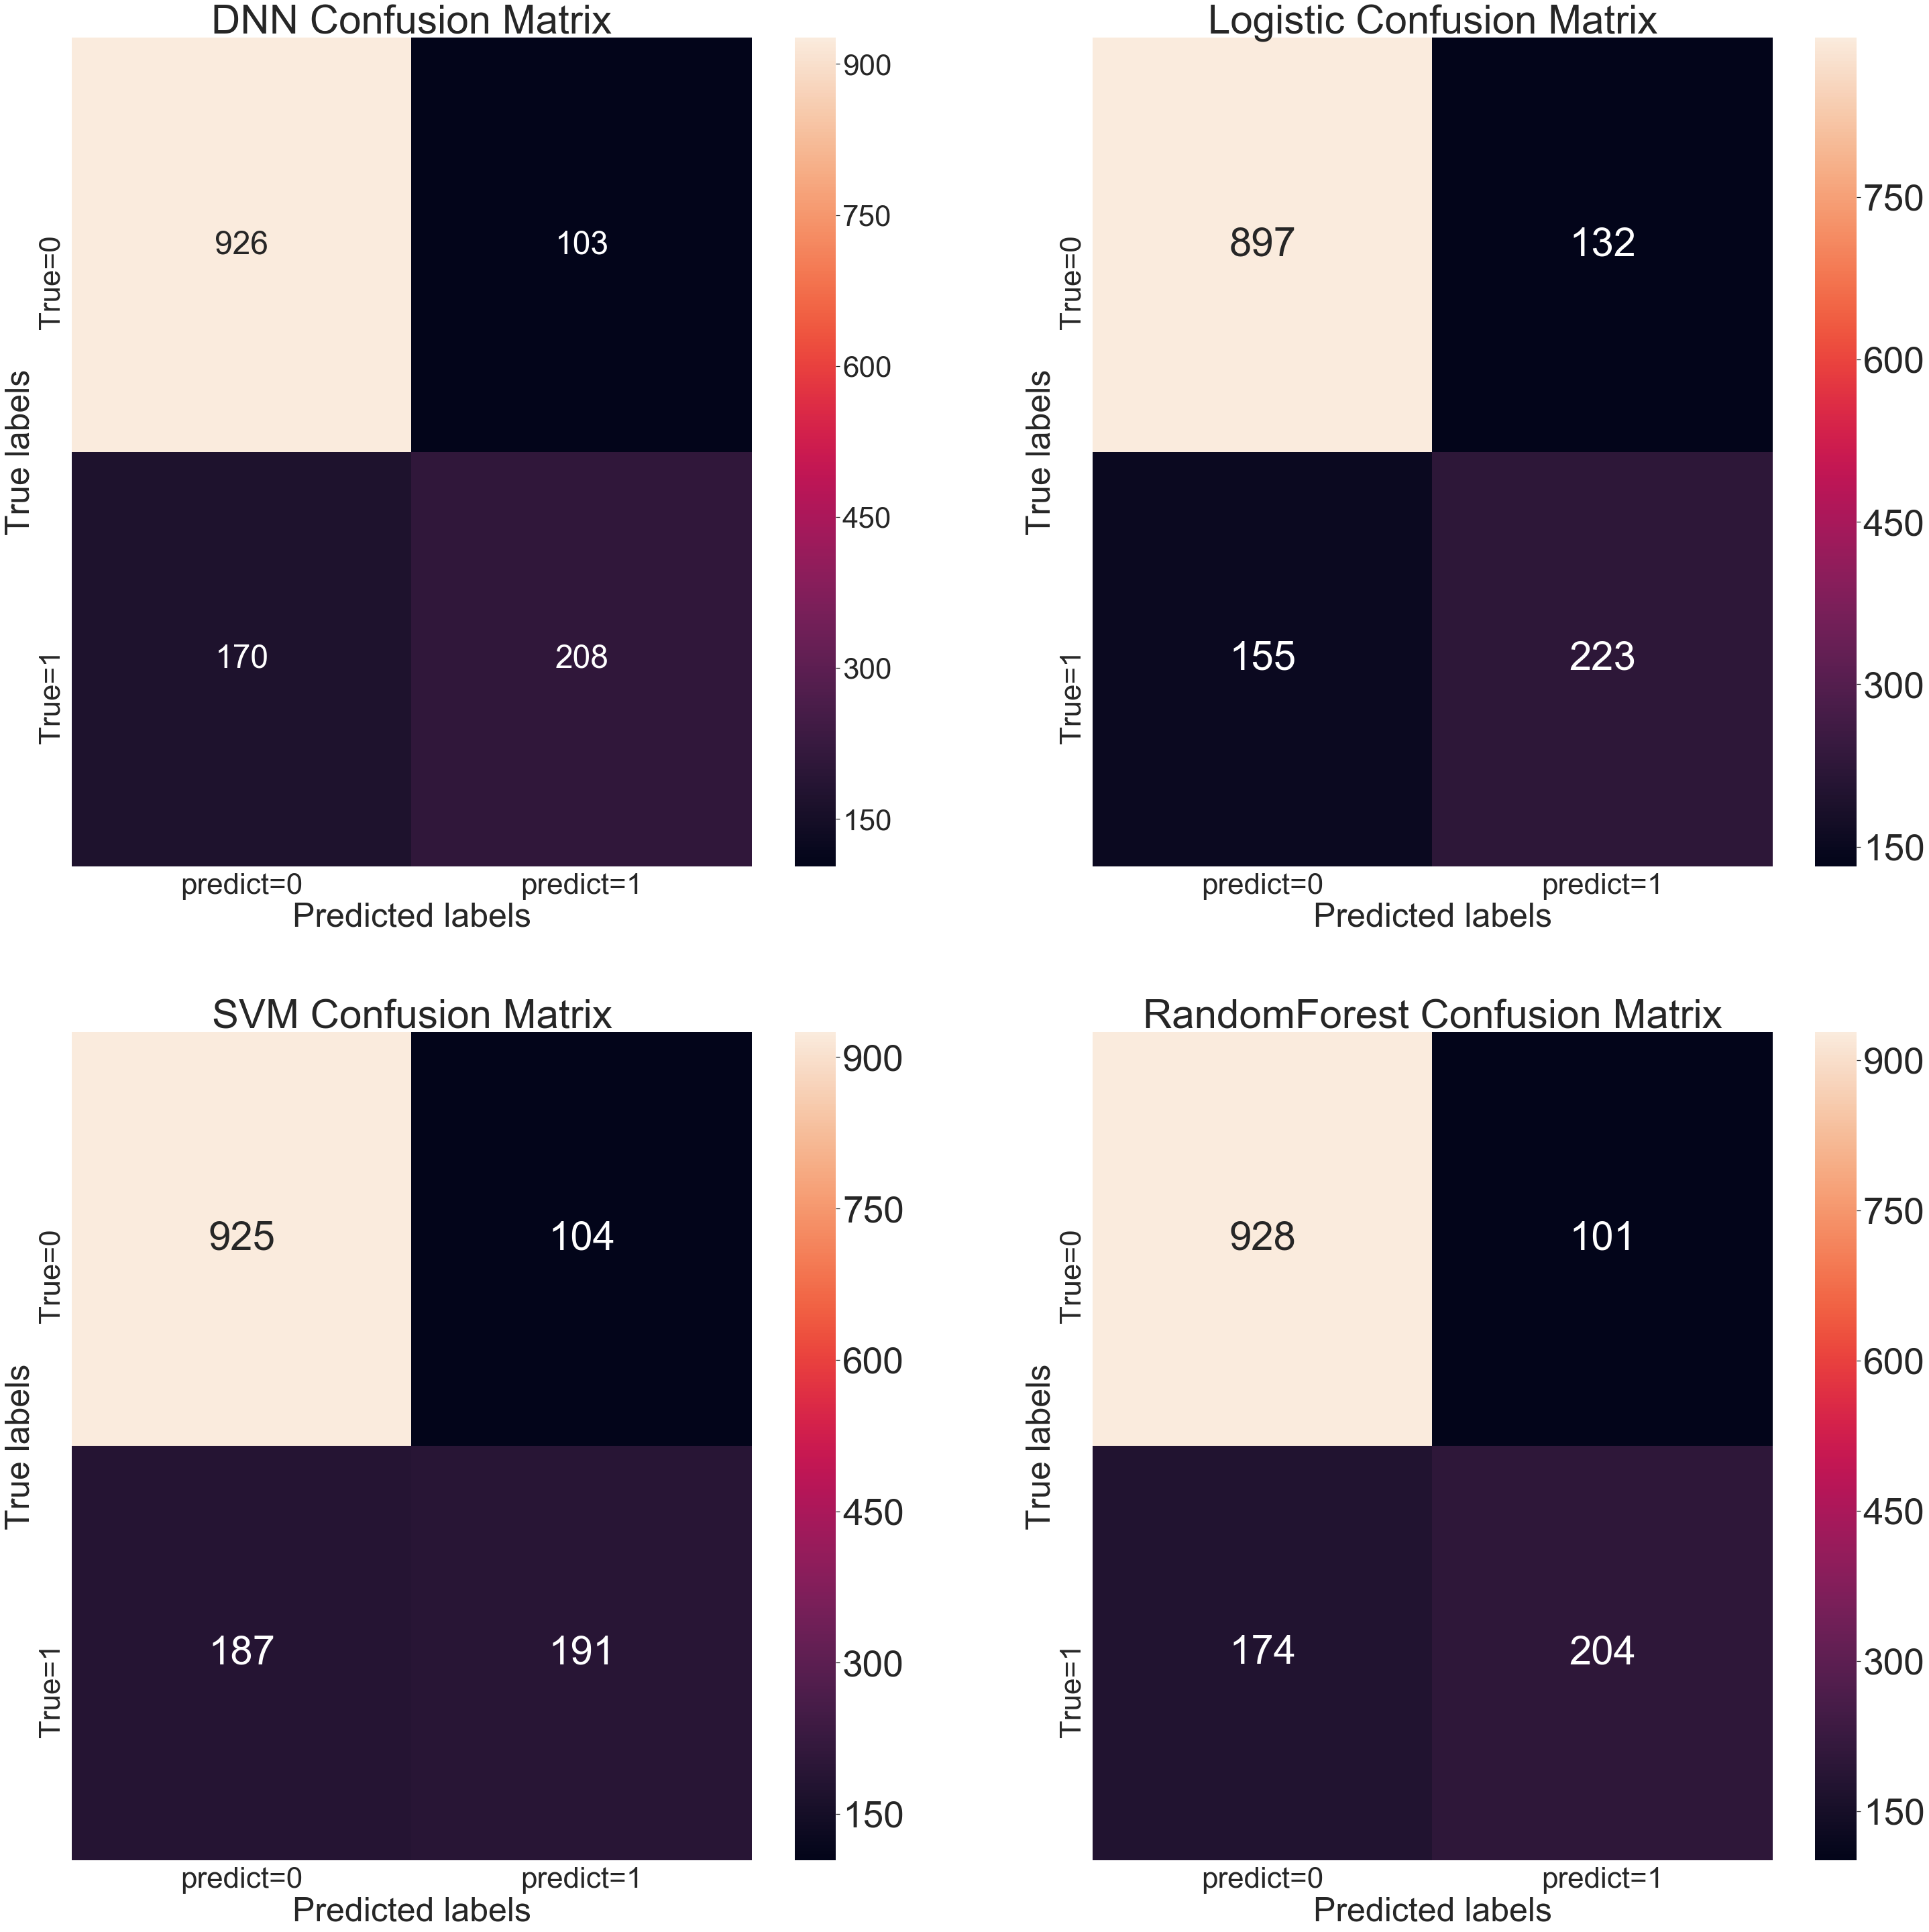

In [256]:
cm_plot ,ax= plt.subplots(nrows=2, ncols=2, figsize=(50,50))
ax = ax.flatten()

model_ls = [model, lr_grid, svc_grid, rf_grid]
name_ls = ['DNN', 'Logistic', 'SVM', 'RandomForest']

for i in range(4):
    
    test_pred = np.round(model_ls[i].predict(x_test))
    cm_train = metrics.confusion_matrix(y_test, test_pred)
    
    matrix = sns.heatmap(cm_train, annot=True, ax = ax[i], fmt='d',
                   xticklabels=['predict=0', 'predict=1'],
                   yticklabels=['True=0', 'True=1']) #annot=True to annotate cells
    sns.set(font_scale=5)
    bottom, top = matrix.get_ylim()
    matrix.set_ylim(bottom + 0.5, top - 0.5)

    ax[i].set_xlabel('Predicted labels', fontsize = 50.0)
    ax[i].set_ylabel('True labels', fontsize = 50.0)
    ax[i].set_title('{} Confusion Matrix'.format(name_ls[i]))

In [257]:
cm_plot.savefig('cm_all_models_50.png')

In [232]:
for i in range(1,4):
    test_pred = model_ls[i].predict(x_test)
    print(name_ls[i])
    print(classification_report(y_test, test_pred))

Logistic
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1029
           1       0.63      0.59      0.61       378

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.74      1407
weighted avg       0.79      0.80      0.79      1407

SVM
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1029
           1       0.65      0.51      0.57       378

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407

RandomForest
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1029
           1       0.67      0.54      0.60       378

    accuracy                           0.80      1407
   macro avg       0.76      0.72      0.73      1407
weighted avg       0.80      0.80      0.80     

In [231]:
test_pred = np.round(model.predict(x_test))
precision, recall, fscore, _= precision_recall_fscore_support(y_test, test_pred)
print('\033[1mClass 0\033[0m')
print('Precision: ', precision[0])
print('Recall: ', recall[0])
print('F-score: ', fscore[0])
print('\033[1mClass 1\033[0m')
print('Precision: ', precision[1])
print('Recall: ', recall[1])
print('F-score: ', fscore[1])
print('\033[1mAverage\033[0m')
print('Precision: ', np.average(precision))
print('Recall: ', np.average(recall))
print('F-score: ', np.average(fscore))

Class 0
Precision:  0.8448905109489051
Recall:  0.8999028182701652
F-score:  0.8715294117647059
Class 1
Precision:  0.6688102893890675
Recall:  0.5502645502645502
F-score:  0.6037735849056604
Average
Precision:  0.7568504001689863
Recall:  0.7250836842673577
F-score:  0.7376514983351832


## Compare data grow vs performance

In [170]:
def datasetSize(n_train, trainX, trainY):
    return trainX[:n_train], trainY[:n_train]
 
def evaluateDNNModel(trainX, trainY, validX, validY):
    model = keras.Sequential([
        keras.layers.Dense(46, activation='relu', input_shape=(46,)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    adam = keras.optimizers.Adam(learning_rate=0.003, decay=0.003/100)
    model.compile(optimizer=adam, loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(trainX, trainY, batch_size=64,
                        epochs=100, validation_data=(validX, validY), verbose=False)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=False)
    return test_acc

def evaluateLR(trainX, trainY, validX, validY):
    lr = LogisticRegression()
    lr.fit(trainX, trainY)
    y_pred_lr = lr.predict(validX)
    return metrics.accuracy_score(validY, y_pred_lr)

def evaluateSVM(trainX, trainY, validX, validY):
    svm = SVC(probability=True, C=100, gamma=0.0001, kernel='rbf')
    svm.fit(trainX, trainY)
    y_pred_svm = svm.predict(validX)
    return metrics.accuracy_score(validY, y_pred_svm)

def evaluateRF(trainX, trainY, validX, validY):
    rfc = RandomForestClassifier(n_estimators=300,
                                 random_state=1234,
                                 max_depth=8, criterion='gini')
    rfc.fit(trainX, trainY)
    y_pred_rfc = rfc.predict(validX)
    return metrics.accuracy_score(validY, y_pred_rfc)

def evaluateSize(n_train, trainX, trainY, validX, validY, n_repeats=5):
    X, Y = datasetSize(n_train, trainX, trainY)
    scoresDNN = list()
    scoresLR = list()
    scoresSVM = list()
    scoresRF = list()
    for _ in range(n_repeats):
        scoresDNN.append(evaluateDNNModel(X, Y, validX, validY))
        scoresLR.append(evaluateLR(X, Y, validX, validY))
        scoresSVM.append(evaluateSVM(X, Y, validX, validY))
        scoresRF.append(evaluateRF(X, Y, validX, validY))
    return scoresDNN, scoresLR, scoresSVM, scoresRF
 
sizes = range(500, 5500, 500)
score_setsDNN, meansDNN = list(), list()
score_setsLR, meansLR = list(), list()
score_setsSVM, meansSVM = list(), list()
score_setsRF, meansRF = list(), list()
for n_train in sizes:
    trainX, validX, trainY, validY = train_test_split(x_train, y_train, test_size=0.2)
    scoresDNN, scoresLR, scoresSVM, scoresRF = evaluateSize(n_train, trainX, trainY, validX, validY)
    score_setsDNN.append(scoresDNN)
    meansDNN.append(np.mean(scoresDNN))
    score_setsLR.append(scoresLR)
    meansLR.append(np.mean(scoresLR))
    score_setsSVM.append(scoresSVM)
    meansSVM.append(np.mean(scoresSVM))
    score_setsRF.append(scoresRF)
    meansRF.append(np.mean(scoresRF))

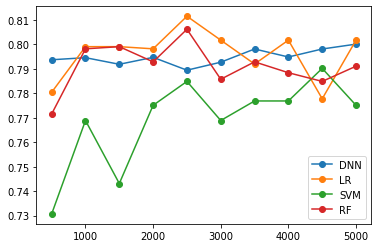

In [172]:
performance_fig, ax = plt.subplots()

ax.plot(sizes, meansDNN, marker='o')
ax.plot(sizes, meansLR, marker='o')
ax.plot(sizes, meansSVM, marker='o')
ax.plot(sizes, meansRF, marker='o')
ax.legend(['DNN', 'LR', 'SVM', 'RF'], loc='lower right')
# performance_fig.savefig('data_increase_500.png')
plt.show()

## All models

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [47]:
classifiers = [['DecisionTree :',DecisionTreeClassifier(criterion="entropy", max_depth=3)],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC(probability=True)],
               ['Neural Network :', MLPClassifier()],
               ['LogisticRegression :', LogisticRegression()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))
    
# Need SVM, logistic, random forest

DecisionTree : 0.814498933901919
RandomForest : 0.7782515991471215
Naive Bayes : 0.6979388770433547
KNeighbours : 0.7668798862828714
SVM : 0.7768301350390903
Neural Network : 0.8137882018479033
LogisticRegression : 0.814498933901919
ExtraTreesClassifier : 0.7739872068230277
AdaBoostClassifier : 0.8137882018479033
GradientBoostingClassifier:  0.8230277185501066
XGB : 0.8208955223880597
CatBoost : 0.8088130774697939


In [51]:
from sklearn.ensemble import VotingClassifier
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression()
clf3 = XGBClassifier()
clf4 = SVC(probability=True)
# eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('ada', clf4)], voting='soft')
eclf1 = VotingClassifier(estimators=classifiers, voting='soft')
eclf1.fit(x_train, y_train)
predictions = eclf1.predict(x_test)
print(accuracy_score(y_test, predictions))

0.8102345415778252


### Clustering Data

In [133]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [134]:
data2 = oneHotEncoded(df.drop(['customerID'], axis=1), categorical_features)
data2['Churn'] = data2['Churn'].map({'Yes': 1, 'No': 0})
data2 = data2[ data2['Churn'] == 1]


In [140]:
data2.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2,2,53.85,108.15,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5,8,99.65,820.50,1,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
8,28,104.80,3046.05,1,1,0,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
13,49,103.70,5036.30,1,0,1,1,0,1,0,...,1,1,0,0,0,1,1,0,0,0


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

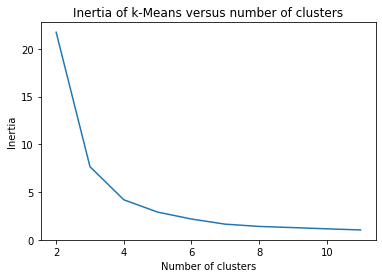

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import preprocessing

normalized_vectors = preprocessing.normalize(data2)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [139]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
# Prepare models
kmeans = KMeans(n_clusters=4).fit(data2)
normalized_vectors = preprocessing.normalize(data2)
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
min_samples = data2.shape[1]+1 
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(data2)
# Print results
print('kmeans: {}'.format(silhouette_score(data2, kmeans.labels_, 
                                           metric='euclidean')))
print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))
print('DBSCAN: {}'.format(silhouette_score(data2, dbscan.labels_, 
                                           metric='cosine')))

kmeans: 0.6469013631027208
Cosine kmeans:0.8638180697300913
DBSCAN: 0.5016208794990787
